In [2]:
from jira import JIRA
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pylab as plt
import nltk 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from torch import nn
import torch
from torchtext import data

In [79]:
server = "https://issues.apache.org/jira/"
jql = 'project = "SPARK"'
options = {"server": server}
conn = JIRA(options, basic_auth=("username", "password"))
issues = pd.DataFrame()

In [80]:
block_size = 1000
block_num = 0
allissues = []
while True:
    start_idx = block_num*block_size
    issues = conn.search_issues(jql, start_idx, block_size)
    if len(issues) == 0: 
      break
    block_num += 1
    for issue in issues:      
      allissues.append(issue)


KeyboardInterrupt



In [ ]:
export_csv = pd.DataFrame(allissues)
export_csv.to_csv('issues.csv')
print(len(allissues))

<class 'list'>
37842


In [3]:
# print(allissues)
import pandas as pd
issues = pd.DataFrame()
# issues = pd.read_csv(r'issues.csv')
for issue in allissues:
    d = pd.DataFrame({
            'key':             [issue.key],
            'assignee':        [str(issue.fields.assignee)],
            'created' :        [str(issue.fields.created)],   
            'labels':          [str(issue.fields.labels)],
            'components':      [str(issue.fields.components)],
            'summary':         [str(issue.fields.summary)],
            'fixVersions':     [str(issue.fields.fixVersions)],
            'issuetype':       [str(issue.fields.issuetype.name)],
            'project':         [str(issue.fields.project)],
            'resolution':      [str(issue.fields.resolution)],
            'resolution_date': [str(issue.fields.resolutiondate)],
            'status':          [str(issue.fields.status.name)],
            'updated':         [str(issue.fields.updated)],
            'versions':        [str(issue.fields.versions)],            
            'watchcount':      [str(issue.fields.watches.watchCount)],    
    })  
    issues = pd.concat([issues, d], ignore_index = False)

print(len(issues))
issues.to_csv('selected_issues.csv')
issues.head()

37842


,key,assignee,created,labels,components,summary,fixVersions,issuetype,project,resolution,resolution_date,status,updated,versions,subtask,watchcount
0,SPARK-38217,None,2022-02-15T10:02:11.000+0000,[],"[<JIRA Component: name='SQL', id='12322623'>]",insert overwrite failed for external table wit...,[],Bug,SPARK,None,None,Open,2022-02-15T10:05:58.000+0000,"[<JIRA Version: name='3.2.1', id='12350582'>]",False,1
1,SPARK-38216,None,2022-02-15T09:39:11.000+0000,[],"[<JIRA Component: name='SQL', id='12322623'>]","When creating a Hive table, fail early if all ...","[<JIRA Version: name='3.3.0', id='12350369'>]",Improvement,SPARK,None,None,In Progress,2022-02-15T09:54:00.000+0000,"[<JIRA Version: name='3.2.0', id='12349407'>]",False,2
2,SPARK-38215,None,2022-02-15T09:19:05.000+0000,[],"[<JIRA Component: name='SQL', id='12322623'>]",InsertIntoHiveDir support convert metadata,[],Task,SPARK,None,None,In Progress,2022-02-15T09:59:08.000+0000,"[<JIRA Version: name='3.2.1', id='12350582'>]",False,2
3,SPARK-38214,None,2022-02-15T08:35:22.000+0000,[],"[<JIRA Component: name='Structured Streaming',...",No need to filter data when the sliding window...,[],Improvement,SPARK,None,None,In Progress,2022-02-15T09:02:01.000+0000,"[<JIRA Version: name='3.2.1', id='12350582'>]",False,2
4,SPARK-38213,None,2022-02-15T06:50:50.000+0000,[],"[<JIRA Component: name='Spark Core', id='12322...",support Metrics information report to kafkaSink.,[],New Feature,SPARK,None,None,Open,2022-02-15T06:53:53.000+0000,"[<JIRA Version: name='3.2.1', id='12350582'>]",False,2


In [3]:
#The target variables 
print(issues.groupby('issuetype').size())

issuetype
Blog - New Blog Request        1
Brainstorming                 49
Bug                        15190
Dependency upgrade            51
Documentation                673
Epic                          29
Github Integration             1
IT Help                       15
Improvement                11390
New Feature                 1999
New JIRA Project               3
Planned Work                   4
Question                     408
Request                       15
Story                        110
Sub-task                    6425
Task                         443
Technical task                 3
Test                         649
Umbrella                     258
Wish                         126
dtype: int64


In [4]:
#removing those who have a low number of entries as would be too hard to train and classify 
issues.drop(issues.index[issues['issuetype'] == "Github Integration"], inplace = True)
issues.drop(issues.index[issues['issuetype'] == "Blog - New Blog Request"], inplace = True)
issues.drop(issues.index[issues['issuetype'] == "IT Help"], inplace = True)
issues.drop(issues.index[issues['issuetype'] == "New JIRA Project"], inplace = True)
issues.drop(issues.index[issues['issuetype'] == "Planned Work"], inplace = True)
issues.drop(issues.index[issues['issuetype'] == "Request"], inplace = True)
issues.drop(issues.index[issues['issuetype'] == "Technical task"], inplace = True)
issues.drop(issues.index[issues['issuetype'] == "Epic"], inplace = True)

In [5]:
print(issues.groupby('issuetype').size())

issuetype
Brainstorming            49
Bug                   15190
Dependency upgrade       51
Documentation           673
Improvement           11390
New Feature            1999
Question                408
Story                   110
Sub-task               6425
Task                    443
Test                    649
Umbrella                258
Wish                    126
dtype: int64


In [6]:
issues.dtypes

key                object
assignee           object
created            object
labels             object
components         object
summary            object
fixVersions        object
issuetype          object
project            object
resolution         object
resolution_date    object
status             object
updated            object
versions           object
subtask              bool
watchcount          int64
dtype: object

In [ ]:
issues.columns

Index(['key', 'assignee', 'created', 'labels', 'components', 'summary',
       'fixVersions', 'issuetype', 'project', 'resolution', 'resolution_date',
       'status', 'updated', 'versions', 'subtask', 'watchcount'],
      dtype='object')

(array([26580.,   443.,  1999.,   673.,  6425.,  1057.,   126.,   258.,
           51.,   159.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

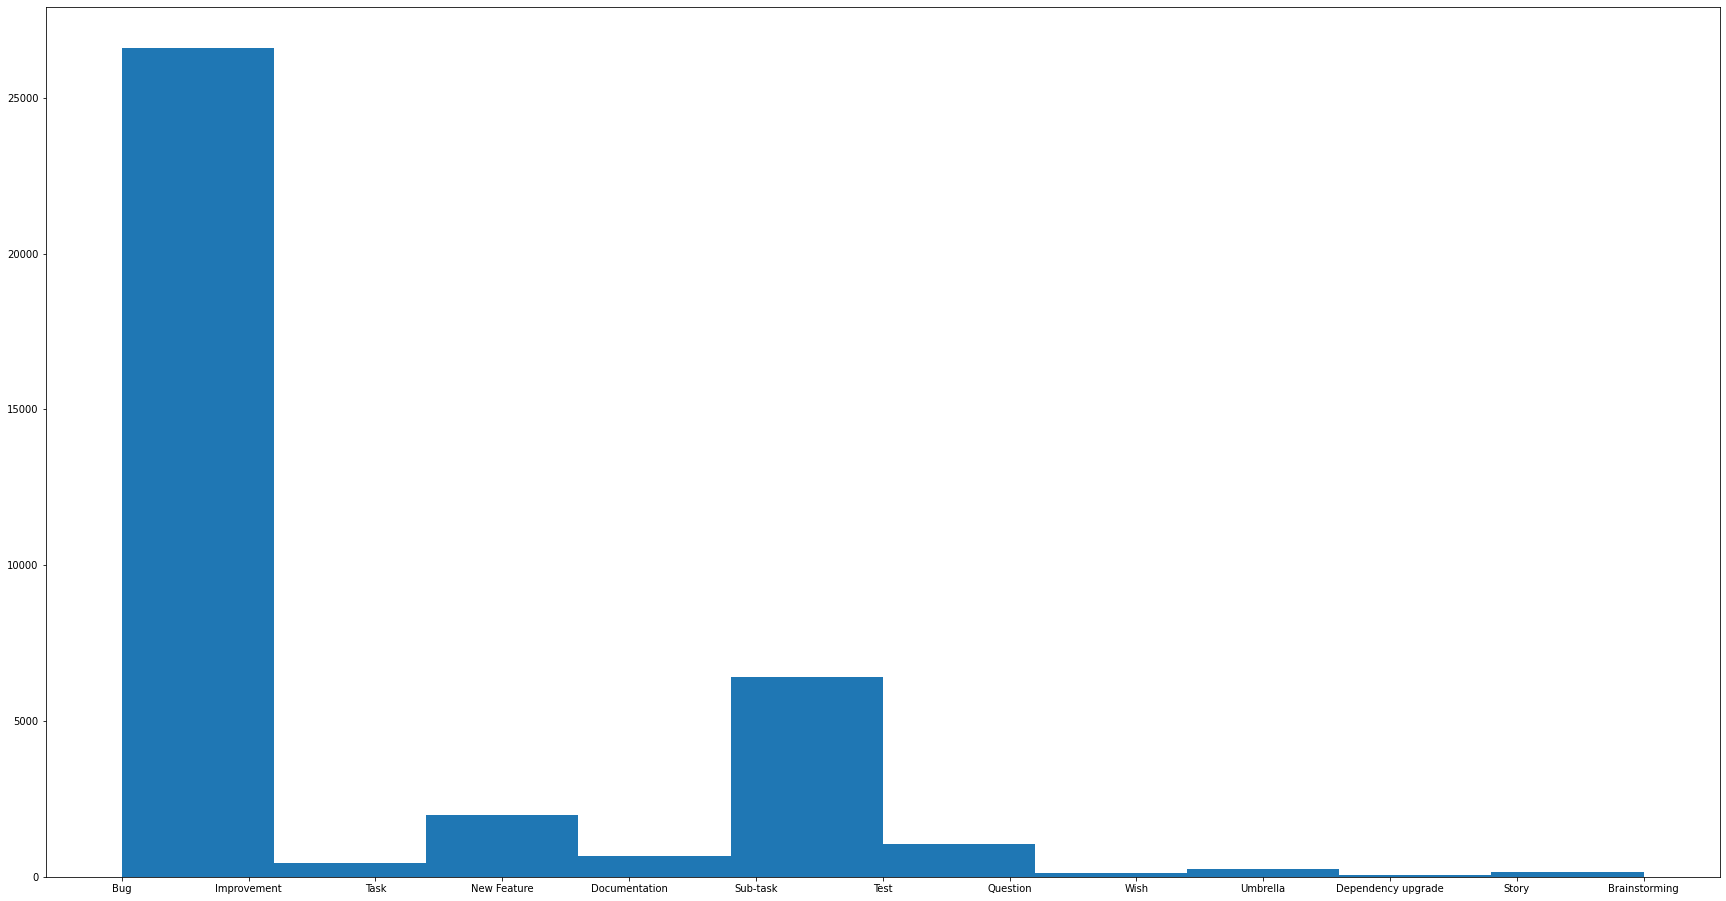

In [7]:
plt.figure(figsize=(30,16))
plt.hist(issues.issuetype)

In [6]:
#removing unnesscary words 
nltk.download('stopwords')
set(stopwords.words('english'))
stop_words = set(stopwords.words('english')) 
issues['summary'].apply(lambda x: [item for item in x if item not in stop_words])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0        [n, e, r,  , v, e, r, w, r, e,  , f, l, e,  , ...
1        [W, h, e, n,  , c, r, e, n, g,  ,  , H, v, e, ...
2        [I, n, e, r, I, n, H, v, e, D, r,  , u, p, p, ...
3        [N,  , n, e, e,  ,  , f, l, e, r,  ,  , w, h, ...
4        [u, p, p, r,  , M, e, r, c,  , n, f, r, n,  , ...
                               ...                        
37837     [D, b, l, e,  , g, p, g,  , b,  , e, f, u, l, .]
37838    [S, p, r, k, C, n, e, x, ., n, e, w, S, h, u, ...
37839    [A, n, g,  , e, p, e, n, e, n, c,  , r, e, p, ...
37840    [R, e, v, n, g,  , c, r, e, e, n, l,  , l, n, ...
37841    [U, e,  , S, P, A, R, K, _, M, A, S, T, E, R, ...
Name: summary, Length: 37771, dtype: object

In [9]:
print(issues.groupby('resolution').size())

resolution
Abandoned                  26
Auto Closed                55
Cannot Reproduce          511
Done                      289
Duplicate                2404
Feedback Received           3
Fixed                   22733
Implemented                42
Incomplete               3345
Information Provided       19
Invalid                  1271
Later                     191
None                     2512
Not A Bug                 105
Not A Problem            1837
Resolved                  101
Won't Do                   92
Won't Fix                2211
Workaround                 20
Works for Me                4
dtype: int64


In [10]:
print(issues.groupby('status').size())

status
Closed          2846
In Progress      963
Open            1501
Reopened          48
Resolved       32413
dtype: int64


In [7]:
issues['joined'] = issues['resolution'] + " " + issues['assignee'] + " " + issues['status'] + " " + issues['summary'].astype(str)

In [34]:
issues['joined'] = issues['joined'].str.lower()
test_issue = issues['joined'][0]
test_issue


'none none open insert overwrite failed for external table with dynamic partition table'

In [11]:
new_y = issues.issuetype
new_x = issues.joined

print(new_x.shape)
print(new_y.shape)

(37771,)
(37771,)


In [12]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=42, shuffle = True, stratify = None)

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(30216,) (7555,) (30216,) (7555,)


In [14]:
y_train.value_counts()

Bug                   12127
Improvement            9186
Sub-task               5133
New Feature            1581
Documentation           530
Test                    511
Task                    349
Question                326
Umbrella                212
Wish                    102
Story                    86
Dependency upgrade       38
Brainstorming            35
Name: issuetype, dtype: int64

In [15]:
y_test.value_counts()

Bug                   3063
Improvement           2204
Sub-task              1292
New Feature            418
Documentation          143
Test                   138
Task                    94
Question                82
Umbrella                46
Story                   24
Wish                    24
Brainstorming           14
Dependency upgrade      13
Name: issuetype, dtype: int64

In [16]:
train = pd.concat([X_train, y_train], axis=1)
print(train.shape)

(30216, 2)


In [19]:
test = pd.concat([X_test, y_test], axis=1)
print(test.shape)

(7555, 2)


In [ ]:
train.to_csv("dsa8021_assignmentTRAIN.csv", index=False)
test.to_csv("dsa8021_assignmentTEST.csv", index=False)

In [17]:
train['issuetype'].unique()


array(['Test', 'Bug', 'Sub-task', 'Improvement', 'Story', 'Task',
       'Umbrella', 'New Feature', 'Wish', 'Question', 'Documentation',
       'Brainstorming', 'Dependency upgrade'], dtype=object)

In [41]:
print(type(issues['joined']))

<class 'pandas.core.series.Series'>


In [ ]:
################ clear data
import string 
from torchtext.vocab import GloVe
all_features = issues['joined']


def preprocessing_featrue(allfeatures):
    english_punctuations = string.punctuation 
    punctuations_list = english_punctuations
    def cleaning_punctuations(joined):
        translator = str.maketrans('', '', punctuations_list)
        return joined.translate(translator)
    allfeatures = allfeatures.apply(lambda joined: cleaning_punctuations(joined))

    embedding_glove = GloVe(name='6B', dim=100)
    X_all_vector = np.zeros((len(allfeatures),100,100))    

    def clearword2vec(clearword, vector):
        i = 0    
        for issue in clearword:
            words = issue.split()
            j = 0
            for word in words:
                vector[i,j] = embedding_glove[word]
                j = j + 1
            i = i + 1        
        return vector
    X_all_vector = clearword2vec(allfeatures, X_all_vector)
    return X_all_vector

X_all_vector = preprocessing_featrue(allfeatures=all_features)
# print(X_all_vector)

In [31]:
# convert muiticlass to categorical
possible_labels = issues['issuetype'].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)
issues['target'] = issues.issuetype.replace(label_dict)


{'Bug': 0, 'Improvement': 1, 'Task': 2, 'New Feature': 3, 'Documentation': 4, 'Sub-task': 5, 'Test': 6, 'Question': 7, 'Wish': 8, 'Umbrella': 9, 'Dependency upgrade': 10, 'Story': 11, 'Brainstorming': 12}


In [20]:
############## convert issuetype to categorical
possible_labels = issues['issuetype'].unique()
num_target_label = len(possible_labels)

def to_categorical(y, num_classes=num_target_label):
    return np.eye(num_classes, dtype=float)[y]

target_value = to_categorical(issues['target'], num_classes=num_target_label)
float_target_value = np.array(target_value)

In [21]:
print(issues['issuetype'])

0                Bug
1        Improvement
2               Task
3        Improvement
4        New Feature
            ...     
37837            Bug
37838            Bug
37839            Bug
37840            Bug
37841            Bug
Name: issuetype, Length: 37771, dtype: object


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_all_vector, target_value, test_size=0.2, random_state=42, shuffle = True, stratify = None)

In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset

batch_size = 3
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

dataset_train = TensorDataset(X_train, y_train)
dataset_val = TensorDataset(X_test, y_test)

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [24]:
# model building
class CNN_Net(nn.Module):
    def __init__(self, num_targetlabel):
        super().__init__()

        self.conv = nn.Sequential()
        self.conv.add_module('conv_1', nn.Conv1d(in_channels=100, out_channels=16, kernel_size=5))
        self.conv.add_module('pool_1', nn.MaxPool1d(kernel_size=2))
        self.conv.add_module('relu_1', nn.ReLU())
        self.conv.add_module('conv_2', nn.Conv1d(in_channels=16, out_channels=128, kernel_size=2))
        self.conv.add_module('pool_2', nn.MaxPool1d(kernel_size=2))
        self.conv.add_module('relu_2', nn.ReLU())

        self.dense = nn.Sequential()
        self.dense.add_module('flatten', nn.Flatten())
        self.dense.add_module('linear', nn.Linear(2944, num_targetlabel))
        self.dense.add_module('sigmoid', nn.Sigmoid())
        
    def forward(self, x):
        x = self.conv(x)
        y = self.dense(x)
        return y        

In [25]:
model = CNN_Net(num_target_label)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN_Net(
  (conv): Sequential(
    (conv_1): Conv1d(100, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=2944, out_features=13, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [26]:
# X_train_vector = np.array(X_train_vector, dtype=np.float32)
# y_train = np.array(y_train, dtype=np.float32)
epochs = 100

In [28]:
def accuracy(y_pred, y_true):
    if type(y_pred)==list:
        y_pred = np.array(y_pred)
    y_pred = (y_pred > 0.5)
    if type(y_true)==list:
        y_true = np.array(y_true)
    acc = (y_pred==y_true).mean()
    return acc

def evaluate_valid(model, progress_bar, device):
    global cfg
    model.eval()
    
    y_true_lst, y_pred_lst = [], []
    with torch.no_grad():
        for batch in progress_bar:
            batch = tuple(b.to(device) for b in batch)
            y_pred = model(batch[0])
            y_pred_lst += list(y_pred.detach().cpu().numpy())
            y_true_lst += list(batch[1].detach().cpu().numpy())            
            
    model.train() 
    acc = accuracy(y_pred_lst, y_true_lst)

    return acc
    
def train(model, progress_bar, optimizer, loss_func, device):
    # global cfg, global_step_num
    model.train()  
    
    y_true_lst, y_pred_lst = [], []    
    
    for batch in progress_bar:
        # global_step_num += 1
        batch = tuple(b.to(device) for b in batch)
        # optimizer.zero_grad()        

        y_pred = model(batch[0])
        train_loss = loss_func(y_pred, batch[1])

        y_pred_lst += list(y_pred.detach().cpu().numpy())
        y_true_lst += list(batch[1].detach().cpu().numpy())

        train_loss.backward()
        optimizer.step()
        model.zero_grad()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(train_loss.item()/len(batch))})
        
    # print('in train(), len(dl_train): ', len(dl_train))
        
    acc = accuracy(y_pred_lst, y_true_lst)
    return acc

print('ok')


ok


In [55]:
from tqdm.notebook import tqdm
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

epochs =3
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    
    progress_bar_train = tqdm(dataloader_train, desc='train Epoch {:1d}'.format(epoch), leave=False, disable=False)    
    train_acc = train(model=model, progress_bar=progress_bar_train, optimizer=optimizer, loss_func=loss_func, device=device)    

    progress_bar_valid = tqdm(dataloader_validation, desc='valid Epoch {:1d}'.format(epoch), leave=False, disable=False)
    valid_acc = evaluate_valid(model=model, progress_bar=progress_bar_valid, device=device)
    print('valid accuracy:', valid_acc)      

  0%|          | 0/3 [00:00<?, ?it/s]

train Epoch 1:   0%|          | 0/10072 [00:00<?, ?it/s]

valid Epoch 1:   0%|          | 0/2519 [00:00<?, ?it/s]

valid accuracy: 0.9228121977294711


train Epoch 2:   0%|          | 0/10072 [00:00<?, ?it/s]

valid Epoch 2:   0%|          | 0/2519 [00:00<?, ?it/s]

valid accuracy: 0.9246958203940335


train Epoch 3:   0%|          | 0/10072 [00:00<?, ?it/s]

valid Epoch 3:   0%|          | 0/2519 [00:00<?, ?it/s]

valid accuracy: 0.9231074683093213


In [54]:
# test model
x_series = pd.Series(test_issue)
test_series = preprocessing_featrue(x_series)
x = torch.tensor(test_series, dtype=torch.float32)
y = model(x)
print(y)
print(label_dict)

(1, 100, 100)
tensor([[0.4290, 0.3116, 0.0096, 0.0464, 0.0141, 0.1665, 0.0182, 0.0098, 0.0033,
         0.0073, 0.0017, 0.0027, 0.0010]], grad_fn=<SigmoidBackward0>)
{'Bug': 0, 'Improvement': 1, 'Task': 2, 'New Feature': 3, 'Documentation': 4, 'Sub-task': 5, 'Test': 6, 'Question': 7, 'Wish': 8, 'Umbrella': 9, 'Dependency upgrade': 10, 'Story': 11, 'Brainstorming': 12}
